<a href="https://colab.research.google.com/github/kaiqizhao/760/blob/master/clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering

We are going to play with the clustering algorithms on both synthetic data and real world data.

First, we need to import some packages.

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import time
import numpy as np
from sklearn.datasets import *
import warnings
warnings.filterwarnings('ignore')

## Synthetic data

We first investigate clustering algorithms on different synthetic datasets. We generate three datasets -- (1) a mixture of four gaussians, (2) two circles and (3) two moon-shaped clusters interleaving each other.

In [0]:
n_samples = 500
gmm = make_blobs(n_samples=n_samples, centers=4,
                       cluster_std=0.60, random_state=0)
circles = make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
moons = make_moons(n_samples=n_samples, noise=.05)

datasets = [gmm, circles, moons]

> Let's visualize these datasets

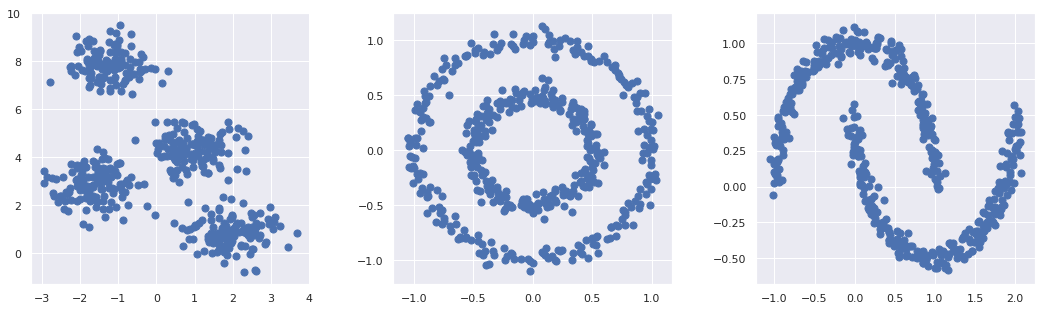

In [0]:
plt.figure(figsize=(18, 5))
plt.subplots_adjust(wspace=.3, hspace=.3)
plot_num = 1
for ds in datasets:
  X, y = ds
  plt.subplot(1, len(datasets), plot_num)
  plt.scatter(X[:, 0], X[:, 1], s=50);
  plot_num += 1

### Kmeans clustering

The first algorithm we apply is K-means. We set the number of clusters the same as the gold standard.

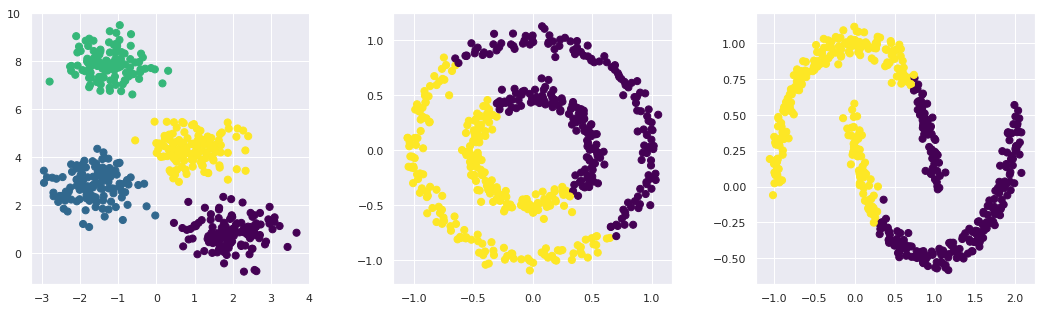

In [0]:
from sklearn.cluster import KMeans

# the number of clusters for each dataset
n_clusters = [4, 2, 2]

plt.figure(figsize=(18, 5))
plt.subplots_adjust(wspace=.3, hspace=.3)
plot_num = 1

kmeans_time = []
for ds, k in zip(datasets, n_clusters):
  X, y = ds
  
  # initialize kmeans with k clusters
  kmeans = KMeans(n_clusters=k)
  
  # run kmeans
  kmeans.fit(X)
  
  # get cluster labels
  y_kmeans = kmeans.labels_.astype(np.int)
  
  # plot the clustering results
  plt.subplot(1, len(datasets), plot_num)
  plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
  plot_num += 1

We can see that k-means does not work well on the later two cases, because they are non-convex.

### Spectral Clustering

Spectral clustering converts the clustering problem to an eigenvalue decompostition problem. I can better handle the non-convex cases.

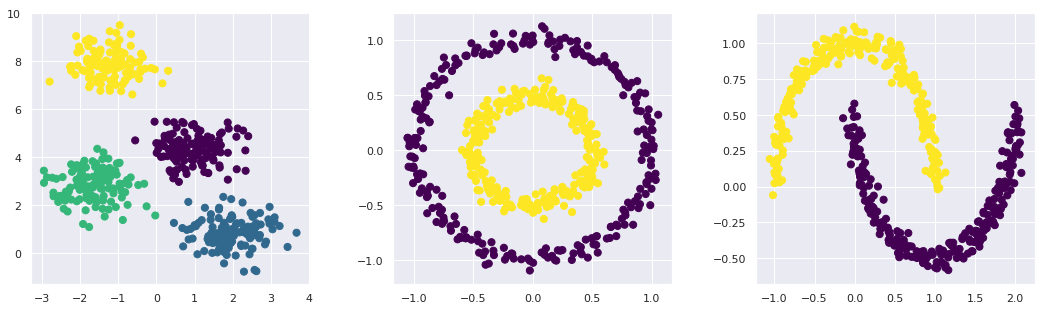

In [0]:
from sklearn.cluster import SpectralClustering

n_clusters = [4, 2, 2]

plt.figure(figsize=(18, 5))
plt.subplots_adjust(wspace=.3, hspace=.3)
plot_num = 1

for ds, k in zip(datasets, n_clusters):
  X, y = ds
  
  # initialize spectral clustering with k clusters. Here, we use nearest 
  # neighbors as affinity to build the graph
  sc = SpectralClustering(n_clusters=k, affinity="nearest_neighbors")
  
  # run the algorithm
  sc.fit(X)
  
  # get cluster labels
  y_sc = sc.labels_.astype(np.int)
  
  # plot the clustering results
  plt.subplot(1, len(datasets), plot_num)
  plt.scatter(X[:, 0], X[:, 1], c=y_sc, s=50, cmap='viridis')
  plot_num += 1

### Hierarchical Agglomerative Clustering

Hierarchical clustering has several types of linkage functions: single-link, complete-link and group-average. You can try any of these linkage functions by passing "single", "complete" or "average" to the linkage parameter of **AgglomerativeClustering**. In this example, we use single-link.

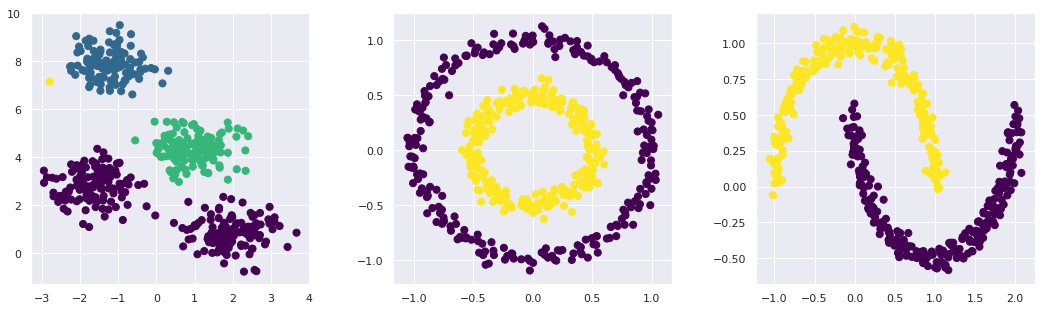

In [0]:
from sklearn.cluster import AgglomerativeClustering

n_clusters = [4, 2, 2]

plt.figure(figsize=(18, 5))
plt.subplots_adjust(wspace=.3, hspace=.3)
plot_num = 1

for ds, k in zip(datasets, n_clusters):
  X, y = ds
  
  # initialize agglomerative clustering with k clusters and single-link
  ac = AgglomerativeClustering(n_clusters=k, linkage="single")
  
  # run the algorithm
  ac.fit(X)
  
  # get cluster labels
  y_ac = ac.labels_.astype(np.int)
  
  # plot the clustering results
  plt.subplot(1, len(datasets), plot_num)
  plt.scatter(X[:, 0], X[:, 1], c=y_ac, s=50, cmap='viridis')
  plot_num += 1

Single-link is able to handle the non-convex case properly. However, it is sensitive to noise as well. From the first figure, we can see that the two classes at the bottom are grouped into one because there are some noisy data points among them. This is called **chaining**.

### Evaluation

We have already visualize the results of the clustering algorithms. For hierarchical clustering, we use average in this case as it is less sensitive to noise and is good at handeling convex datasets.

Now, we try to analyze them quantitatively. Specifically, we record the runtime and the NMI score w.r.t. different dataset sizes. The NMI score is computed by comparing the clustering results to the gold standard class labels. 

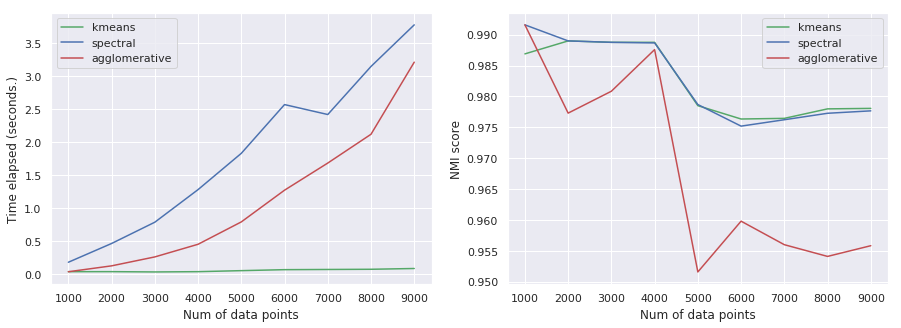

In [0]:
from sklearn import metrics

# Initialize the three algorithms
kmeans = KMeans(n_clusters=4)
sc = SpectralClustering(n_clusters=4, affinity="nearest_neighbors")
ac = AgglomerativeClustering(n_clusters=4, linkage="average")

algorithms = {'kmeans':kmeans, 'spectral':sc, 'agglomerative':ac}
time_cost = {'kmeans':[], 'spectral':[], 'agglomerative':[]}
nmi_score = {'kmeans':[], 'spectral':[], 'agglomerative':[]}

# data size from 1000 to 9000
n_samples_list = range(1000, 10000, 1000)

for n_samples in n_samples_list:  
  X, g = make_blobs(n_samples=n_samples, centers=4,
                         cluster_std=0.60, random_state=0)
  for algo in algorithms:
    t_start = time.time()
    algorithms[algo].fit(X)
    t_end = time.time()
    time_cost[algo].append(t_end - t_start)
    
    y = algorithms[algo].labels_.astype(np.int)
    nmi = metrics.normalized_mutual_info_score(g, y)
    nmi_score[algo].append(nmi)

# plot figures of runtime and nmi
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(n_samples_list, time_cost['kmeans'], 'g-',
        n_samples_list, time_cost['spectral'], 'b-',
        n_samples_list, time_cost['agglomerative'], 'r-')
ax1.set_xlabel('Num of data points')
ax1.set_ylabel('Time elapsed (seconds.)')
ax1.legend(('kmeans','spectral','agglomerative'))

ax2.plot(n_samples_list, nmi_score['kmeans'], 'g-',
        n_samples_list, nmi_score['spectral'], 'b-',
        n_samples_list, nmi_score['agglomerative'], 'r-')
ax2.set_xlabel('Num of data points')
ax2.set_ylabel('NMI score')
ax2.legend(('kmeans','spectral','agglomerative'))

We observe that k-means is scalable to large dataset, as its runtime is linear to the data size. The NMI scores all the algorithms are almost perfect >0.95. 

Now, we turn to investigate how the number of clusters affects the algorithms. Here, we set the number of clusters from 5 to 45.

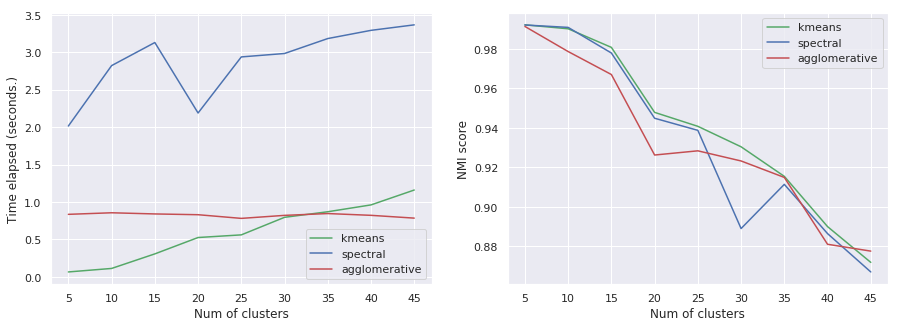

In [0]:
time_cost = {'kmeans':[], 'spectral':[], 'agglomerative':[]}
nmi_score = {'kmeans':[], 'spectral':[], 'agglomerative':[]}

n_clusters_list = range(5, 50, 5)
for n_clusters in n_clusters_list:  
  X, g = make_blobs(n_samples=5000, centers=n_clusters,
                         cluster_std=0.60, random_state=0)
  
  kmeans = KMeans(n_clusters=n_clusters)
  sc = SpectralClustering(n_clusters=n_clusters, affinity="nearest_neighbors")
  ac = AgglomerativeClustering(n_clusters=n_clusters, linkage="average")

  algorithms = {'kmeans':kmeans, 'spectral':sc, 'agglomerative':ac}
  
  for algo in algorithms:
    t_start = time.time()
    algorithms[algo].fit(X)
    t_end = time.time()
    time_cost[algo].append(t_end - t_start)
    
    y = algorithms[algo].labels_.astype(np.int)
    nmi = metrics.normalized_mutual_info_score(g, y)
    nmi_score[algo].append(nmi)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(n_clusters_list, time_cost['kmeans'], 'g-',
        n_clusters_list, time_cost['spectral'], 'b-',
        n_clusters_list, time_cost['agglomerative'], 'r-')
ax1.set_xlabel('Num of clusters')
ax1.set_ylabel('Time elapsed (seconds.)')
ax1.legend(('kmeans','spectral','agglomerative'))

ax2.plot(n_clusters_list, nmi_score['kmeans'], 'g-',
        n_clusters_list, nmi_score['spectral'], 'b-',
        n_clusters_list, nmi_score['agglomerative'], 'r-')
ax2.set_xlabel('Num of clusters')
ax2.set_ylabel('NMI score')
ax2.legend(('kmeans','spectral','agglomerative'))

K-means still has best runtime when the number of clusters is small, but it has runtime linear to the number of clusters. On the other hand, agglomerative clustering is not so sensitive to the number of clusters. If the number of clusters increases, the number of merging in agglomerative clustering decreases and thus the runtime decreases.

As the number of clusters increases, the problem becomes much more complex. This is why all the algorithms show a significant performance drop (see the NMI curve) when the number of clusters increases.

## Real-world data

### Digit data

The digit data is included in the scikit-learn package. The datasets has 1,797 samples of hand-written digits (0-9). Each sample is an image of a particular digit of size 8x8. As a result, each sample is represented by a 64-dimension vector. Our goal is to group the images by different digits from 0-9.

More details can be found: https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.11-K-Means.ipynb


First, we need to load the digit dataset.

In [0]:
from sklearn.datasets import load_digits
digits = load_digits()

We totally have 10 different digits from 0-9. So, a reasonable choice of number of clusters is 10. Use k-means to cluster the images into 10 clusters.

In [0]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)

Then, we can see how do the centers look like. This is simple, because the center is also a 64-dimension vector and can be reconstructed to an image.

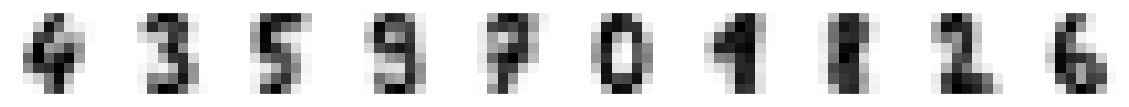

In [0]:
fig, ax = plt.subplots(1, 10, figsize=(20, 1.5))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, cmap=plt.cm.binary)

Now, we can see the recontructed images from the centers of the clusters. Each of them captures the characteristics of the digits. As human, we can tell the 10 centers correspond to 4, 3, 5, 9, 7, 0, 1, 8, 2, 6. However, for machines, they cannot find such link directly. Instead, we need to link the clusters to their most likely classes.

In [0]:
cluster_to_class = []
for i in range(10):
    # select the data that assigned to the currect cluster i
    mask_c = (clusters == i)
    # compare the data assigned to cluster i and class j, and compute the
    # number of interaction of cluster i with each class j
    c_g = [sum(np.logical_and(mask_c, (digits.target == j))) 
           for j in range(0, 10)]
    # select the class label that has largest intersection with cluster i
    cluster_to_class.append(np.argmax(c_g))
    
cluster_to_class

[4, 3, 5, 9, 7, 0, 1, 8, 2, 6]

To this end, we get a mapping from clusters to classes. It is consistent with our perception. If we map the cluster labels to the corresponding class labels, e.g., cluster 0 --> class 4, we can compute the accuracy of k-means for recognizing these digits.

In [0]:
labels = np.zeros_like(clusters)
for i in range(10):
  mask_c = (clusters == i)
  labels[mask_c] = cluster_to_class[i]

from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7935447968836951

Using a simple k-means clustering, we have reached a 79% accuracy. From the visualization of the centers, we can see the centers of digit 1 and digit 8 looks similar. This means the algorithm may not be able to distinguish these two cases. To have insight view of this, we can compute a confusion matrix of cluster labels and class labels. Each entry in the matrix corresponds to the number of samples belonging to class j are assigned to cluster i.

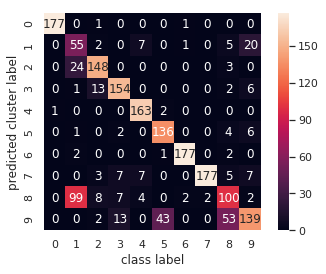

In [0]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d',
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('class label')
plt.ylabel('predicted cluster label');

See the red entry at the left bottom. We have 99 samples of digit 1 recognized as digit 8 using k-means. How if we use spectral clustering?

In [0]:
# spectral clustering
sc = SpectralClustering(n_clusters=10, affinity="nearest_neighbors")
clusters = sc.fit_predict(digits.data)

# map the cluster labels to class labels
labels = np.zeros_like(clusters)
for i in range(10):
    mask_c = (clusters == i)
    c_g = [sum(np.logical_and(mask_c, (digits.target == j))) 
           for j in range(0, 10)]
    labels[mask_c] = np.argmax(c_g)    

# compute accuracy
accuracy_score(digits.target, labels)

0.8230383973288815

We have a 4% accuracy improvment using spectral clustering. Let's compute the confusion matrix again.

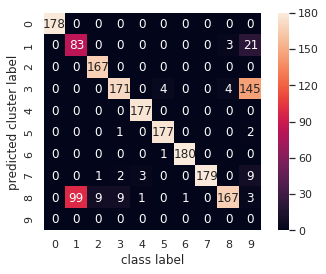

In [0]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d',
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('class label')
plt.ylabel('predicted cluster label');

Spectral clustering can better distinguish 1 and 2, but it cannot recognize 9. It is confused by 3 and 9 in most of the cases.

Sometime, it is important to transform the original vector space to a more compact space in order to better distinguish different clusters. This is call dimension reduction. More details of dimension reduction can be found in the book "Elements of statistical learning". Here, we can simply apply a method called t-distributed stochastic neighbor embedding (t-SNE). This method is an effective non-linear transformation method for dimension reduction. It is widely used in many machine learning tasks.

In [0]:
from sklearn.manifold import TSNE

# transform the data to a 2-d space
tsne = TSNE(n_components=2, init='random', random_state=0)
digits_proj = tsne.fit_transform(digits.data)

# kmeans
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits_proj)

# map the cluster labels to class labels
labels = np.zeros_like(clusters)
for i in range(10):
    mask_c = (clusters == i)
    c_g = [sum(np.logical_and(mask_c, (digits.target == j))) 
           for j in range(0, 10)]
    labels[mask_c] = np.argmax(c_g)    

# compute the accuracy
accuracy_score(digits.target, labels)

0.9326655537006121

Then, we can compute the confusion matrix.

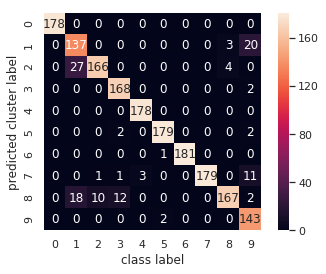

In [0]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d',
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('class label')
plt.ylabel('predicted cluster label');

By projecting the data to a 2-D space, in most of the cases, we can distinguish the digits now. Let's see how are the cluster centers now.

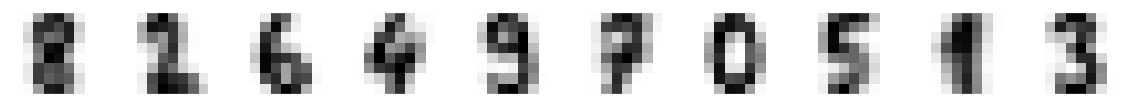

In [0]:
# compute the centers of each cluster
centers = np.zeros((10, 64), dtype=np.float)
for i in range(10):
  mask = (clusters == i)
  centers[i,:] = sum(digits.data[mask])

centers = centers.reshape(10, 8, 8)

# reconstruct the images from centers
fig, ax = plt.subplots(1, 10, figsize=(20, 1.5))
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, cmap=plt.cm.binary)

Now, 1 and 8 are more distinguishable in shape.

### News articles

Next, we play with text data. The 20 news groups datasets has around 18000 posts on 20 topics.

First, we fetch the dataset.

In [0]:
from sklearn.datasets import fetch_20newsgroups

dataset = fetch_20newsgroups(subset='all', shuffle=True, random_state=0)

We can check the 20 topics of the news.

In [0]:
list(dataset.target_names)

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Before using k-means, we need to convert each news article into a numeric vector. TF-IDF is often used for generating the vector representation of a document. More about TF-IDF, refer to https://en.wikipedia.org/wiki/Tf%E2%80%93idf

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english',
                            use_idf=True)
X = vectorizer.fit_transform(dataset.data)

Run kmeans to group the news articles into 20 clusters. This time, we initialize the centers using kmeans++

In [0]:
kmeans = KMeans(n_clusters = 20, init='k-means++', max_iter=50, n_init=1, 
                verbose=True)
clusters = kmeans.fit_predict(X)

Initialization complete
Iteration  0, inertia 35550.521
Iteration  1, inertia 18413.554
Iteration  2, inertia 18327.098
Iteration  3, inertia 18283.757
Iteration  4, inertia 18260.459
Iteration  5, inertia 18249.102
Iteration  6, inertia 18242.542
Iteration  7, inertia 18237.013
Iteration  8, inertia 18232.495
Iteration  9, inertia 18229.291
Iteration 10, inertia 18227.216
Iteration 11, inertia 18226.001
Iteration 12, inertia 18225.144
Iteration 13, inertia 18224.394
Iteration 14, inertia 18223.548
Iteration 15, inertia 18221.992
Iteration 16, inertia 18219.940
Iteration 17, inertia 18217.531
Iteration 18, inertia 18214.725
Iteration 19, inertia 18214.471
Iteration 20, inertia 18214.398
Iteration 21, inertia 18214.347
Iteration 22, inertia 18214.320
Iteration 23, inertia 18214.309
Iteration 24, inertia 18214.293
Iteration 25, inertia 18214.284
Converged at iteration 25: center shift 0.000000e+00 within tolerance 1.309554e-09


We can check the articles grouped to each topic.

In [0]:
for i in range(20):  
  docs_i = [x for d, x in enumerate(dataset.data) if clusters[d] == i]
  print('Topic {}: '.format(i), docs_i[:10])

Topic 0:  ['From: baalke@kelvin.jpl.nasa.gov (Ron Baalke)\nSubject: Magellan Update - 04/23/93\nOrganization: Jet Propulsion Laboratory\nLines: 34\nDistribution: world\nNNTP-Posting-Host: kelvin.jpl.nasa.gov\nKeywords: Magellan, JPL\nNews-Software: VAX/VMS VNEWS 1.41    \n\nForwarded from Doug Griffith, Magellan Project Manager\n\n                     MAGELLAN STATUS REPORT\n                         April 23, 1993\n\n1.  The Magellan spacecraft continues to operate normally, gathering\ngravity data to plot the density variations of Venus in the\nmid-latitudes.  The solar panel offpoint was returned to zero degrees\nand spacecraft temperatures dropped 2-3 degrees C.\n\n2.  An end-to-end test of the Delayed Aerobraking Data readout\nprocess was conducted this week in preparation for the Transition\nExperiment.  There was some difficulty locking up to the data frames,\nand engineers are presently checking whether the problem was in\nequipment at the tracking station.\n\n3.  Magellan has c

Sometimes, it is diffcult to understand the topics by looking at the documents. Let's summarize the representative words for each topics. Each word is a dimension of the cluster center. So, to get most representative words for a cluster, we only need to select the dimensions of its center vector that have largest values.

In [0]:
terms = vectorizer.get_feature_names()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

for i in range(20):
  print("Cluster {}:".format(i), 
        ' '.join([terms[j] for j in order_centroids[i, :10]]))

Cluster 0: nasa space gov jpl alaska shuttle jsc larc gsfc launch
Cluster 1: key clipper encryption chip keys escrow government com algorithm des
Cluster 2: com university article posting host nntp cs ca know like
Cluster 3: cmu andrew carnegie mellon pittsburgh pa ax host nntp posting
Cluster 4: god jesus bible christians christ christian people believe faith sin
Cluster 5: card video bus mouse drivers monitor cards diamond vga windows
Cluster 6: car bike com dod cars engine article ca like just
Cluster 7: netcom com sun 408 9760 241 guest services east microsystems
Cluster 8: henry toronto zoo spencer zoology utzoo kipling launch svr3 orbit
Cluster 9: scsi drive ohio magnus ide state acs hard drives controller
Cluster 10: uk ac university mathew ai demon uga cam georgia mantis
Cluster 11: game team hockey games ca year players season play espn
Cluster 12: gun people guns geb pitt banks gordon don com government
Cluster 13: stratus fbi cramer com batf optilink koresh sw atf people
Clu

For example, we can see the first cluster as a topic of "sci.space", the second topic is "sci.crypt". Often, the word distribution of a cluster can be computed and visualized as word clouds. Next, we try to visualize the topics.

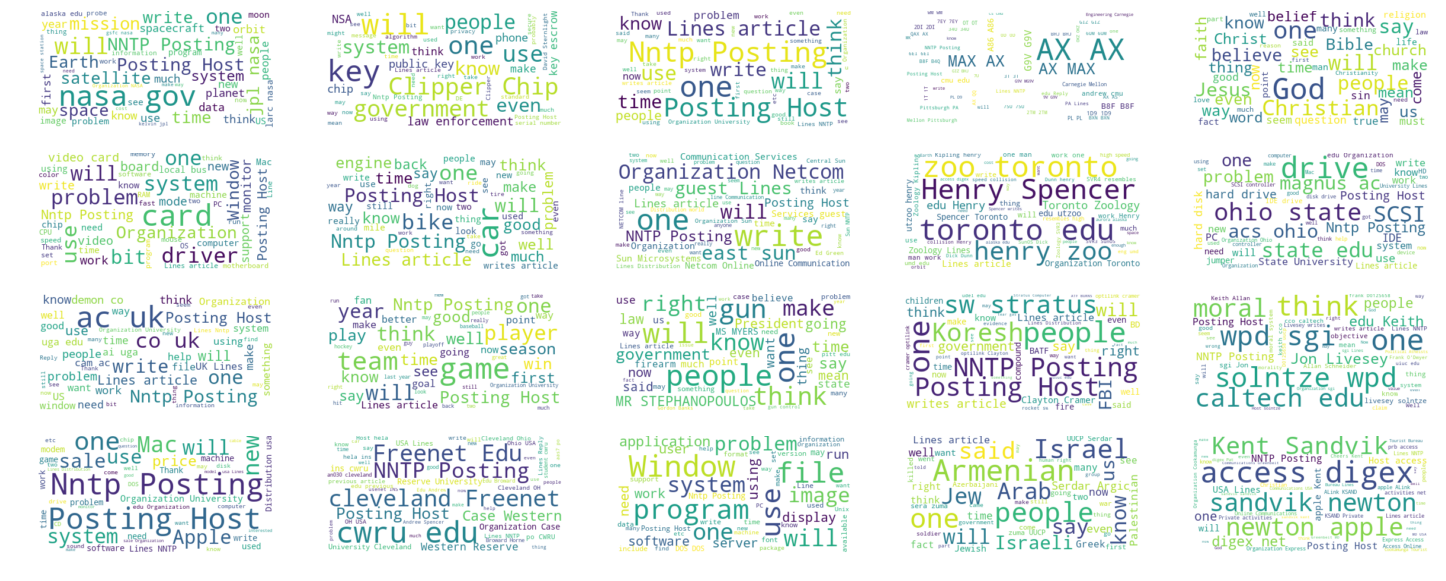

In [0]:
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)
stopwords.update(["Re", "Subject"])

plt.figure(figsize=(25, 10))
plot_num = 1

for i in range(20):
  docs_i = [x for d, x in enumerate(dataset.data) if clusters[d] == i]
  word_cloud = WordCloud(max_font_size=50, max_words=50, stopwords = stopwords,
                         background_color="white").generate(' '.join(docs_i))
  
  plt.subplot(4, 5, plot_num)
  plt.imshow(word_cloud, interpolation='bilinear')
  plt.axis("off")
  plot_num += 1